# Moje modele 1.7 - 27 kwiecień 2020 [''Stroke_Prediction'']

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings 

warnings.filterwarnings("ignore")

%matplotlib inline

df= pd.read_csv('/home/wojciech/Pulpit/1/Stroke_Prediction.csv')
print(df.shape)
print()
print(df.columns)
df.head(3)

(43400, 12)

Index(['ID', 'Gender', 'Age_In_Days', 'Hypertension', 'Heart_Disease',
       'Ever_Married', 'Type_Of_Work', 'Residence', 'Avg_Glucose', 'BMI',
       'Smoking_Status', 'Stroke'],
      dtype='object')


,ID,Gender,Age_In_Days,Hypertension,Heart_Disease,Ever_Married,Type_Of_Work,Residence,Avg_Glucose,BMI,Smoking_Status,Stroke
0,31153,Male,1104.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30650,Male,21204.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,17412,Female,2928.0,0,0,No,Private,Urban,110.89,17.6,NaN,0


### <span style="color:green"> Kasuje bezsensowne kolumny

In [2]:
# del df['Unnamed: 0']
# del df['Unnamed: 0.1']

### <span style="color:green"> Wielkość bazy df jest ogromna - wyciągam tylko 100% losowo wybranych rekordów</span> 
Taka metoda jest najbardziej reprezentatywna i oszczędza zasoby komputera.

In [3]:
df2 = df.sample(frac = 1.0, random_state=10)
df2.shape

(43400, 12)

## <span style="color:green"> Wyświetlenie braków </span>  (własnej roboty)

In [4]:
a,b = df2.shape     #<- ile mamy kolumn
b

print('NUMBER OF EMPTY RECORDS vs. FULL RECORDS')
print('----------------------------------------')
for i in range(1,b):
    i = df2.columns[i]
    r = df2[i].isnull().sum()
    h = df2[i].count()
    pr = (r/h)*100
   
    if r > 0:
        print(i,"--------",r,"--------",h,"--------",pr) 

NUMBER OF EMPTY RECORDS vs. FULL RECORDS
----------------------------------------
BMI -------- 1462 -------- 41938 -------- 3.4860985263961086
Smoking_Status -------- 13292 -------- 30108 -------- 44.14773482130995


## <span style="color:green"> Nie warto kasować rekordów z brakami tylko warto wstawiać tam wartości z poza zakresu </span>

Wyszukuje tylko puste rekordy

In [5]:
null_value_stats = df2.isnull().sum(axis=0)
null_value_stats[null_value_stats != 0]

BMI                1462
Smoking_Status    13292
dtype: int64

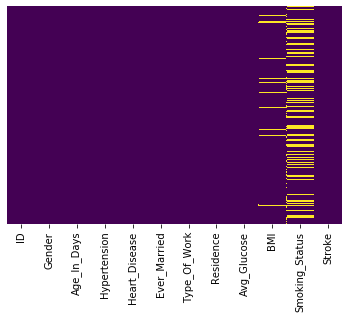

In [6]:
import seaborn as sns

sns.heatmap(df2.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Wstawia w puste miejsca wartości z poza zakresu

In [7]:
df2.fillna(7777, inplace=True)

## <span style="color:green"> Przegląd danych pod kontem formatu i ilości wartości unikalnych</span>  (własnej roboty)

In [8]:
a,b = df2.shape     #<- ile mamy kolumn
b

import numpy as np

for i in range(1,b):
    i = df2.columns[i]
    h = df2[i].nunique()
    f = df2[i].dtypes
          
    print(f,'---nunique->',h,'---name->', i)

object ---nunique-> 3 ---name-> Gender
float64 ---nunique-> 4848 ---name-> Age_In_Days
int64 ---nunique-> 2 ---name-> Hypertension
int64 ---nunique-> 2 ---name-> Heart_Disease
object ---nunique-> 2 ---name-> Ever_Married
object ---nunique-> 5 ---name-> Type_Of_Work
object ---nunique-> 2 ---name-> Residence
float64 ---nunique-> 12543 ---name-> Avg_Glucose
float64 ---nunique-> 556 ---name-> BMI
object ---nunique-> 4 ---name-> Smoking_Status
int64 ---nunique-> 2 ---name-> Stroke


## <span style="color:green"> Które z tych funkcji są kategoryczne?</span> (własnej roboty)

Stawiam dwa warunki: 

1. funkcja jest kategoryczna bo ma format 'object'
2. funkcja jest kategoryczna bo ma do 10 unikalnych wartości

In [9]:
a,b = df2.shape     #<- ile mamy kolumn
b

print('ONLY DISCRETE FUNCTION')
print('----------------------')
for i in range(1,b):
    i = df2.columns[i]
    f = df2[i].dtypes
    h = df2[i].nunique()
    
    if f == np.object or h<=10:
        print(i,"---",f,"---",h)

ONLY DISCRETE FUNCTION
----------------------
Gender --- object --- 3
Hypertension --- int64 --- 2
Heart_Disease --- int64 --- 2
Ever_Married --- object --- 2
Type_Of_Work --- object --- 5
Residence --- object --- 2
Smoking_Status --- object --- 4
Stroke --- int64 --- 2


#### Potrzebujemy listy z numerami kolumnaby użyć jej w CatBoost¶

In [10]:
import numpy as np
a,b = df2.shape     #<- ile mamy kolumn
b

print()
categorical_fun = np.where((df2.dtypes == np.object)|(df2.nunique() <= 15))[0]
x1 = len(categorical_fun)
print('categorical_fun: ',x1)
print('categorical_fun: ',categorical_fun)
print()
numerical_fun = np.where((df2.dtypes != np.object)&(df2.nunique() > 15))[0]
x2 = len(numerical_fun)
print('numerical_fun: ',x2)
print('numerical_fun: ',numerical_fun)
print()
print('LICZBA KOLUMN MA SIĘ ZGADZAĆ!')
print('all columns:                     ',b)
print('numerical_fun + categorical_fun: ',x1+x2)


categorical_fun:  8
categorical_fun:  [ 1  3  4  5  6  7 10 11]

numerical_fun:  4
numerical_fun:  [0 2 8 9]

LICZBA KOLUMN MA SIĘ ZGADZAĆ!
all columns:                      12
numerical_fun + categorical_fun:  12


## <span style="color:red"> Uwaga! 
#### <span style="color:red">    1. dane categorialne nie muszą mieć tylko formatu tekstowego, 

#### <span style="color:red">    2. dane tekstowe trzeba przerobić do formatu numerycznego 

### <span style="color:green"> Narzędzie do automatycznego kodowania zmiennych dyskretnych </span>(własnej roboty)


In [11]:
a,b = df2.shape     #<- ile mamy kolumn
b

print('DISCRETE FUNCTIONS CODED')
print('------------------------')
for i in range(1,b):
    i = df2.columns[i]
    f = df2[i].dtypes
    if f == np.object:
        print(i,"---",f)   
    
        if f == np.object:
        
            df2[i] = pd.Categorical(df2[i]).codes
        
            continue

DISCRETE FUNCTIONS CODED
------------------------
Gender --- object
Ever_Married --- object
Type_Of_Work --- object
Residence --- object
Smoking_Status --- object


### <span style="color:green"> Narzędzie do automatycznej zmiany znaku na plus </span>(własnej roboty)

In [12]:
df2.head()

,ID,Gender,Age_In_Days,Hypertension,Heart_Disease,Ever_Married,Type_Of_Work,Residence,Avg_Glucose,BMI,Smoking_Status,Stroke
40901,57244,0,17546.0,0,0,1,2,1,56.54,35.9,2,0
35943,12001,0,20844.0,0,0,1,2,0,86.48,23.8,2,0
34620,25334,0,29612.0,0,0,1,2,0,86.86,31.7,2,0
15550,52679,0,16455.0,0,0,1,2,1,79.49,31.6,2,0
40360,40046,0,28872.0,0,0,1,3,0,80.47,28.0,2,0


### <span style="color:green">Szukamy ujemnych wartości i je zmieniamy (przesuwamy) aby były dodatnie
Filtr Ch2 nie lubi ujemnych wartości

In [13]:
a,b = df2.shape     #<- ile mamy kolumn
b

print('NEGATIVE VALUES')
print('---------------')
for i in range(1,b):
    i = df2.columns[i]
    f = df2[i].min()
    if f < 0: 
        print(i,"---",f)

NEGATIVE VALUES
---------------
Age_In_Days --- -16381.0


#### Najpierw trzeba się upewnić czy ujemna wartość to nie jest ewidentny błąd

In [14]:
(df2['Age_In_Days']==-16381.0).sum()

1

In [15]:
df2['Age_In_Days'] = df2['Age_In_Days'].replace(-16381.0,0)

#### usuwamy wartości ujemne (przesuwamy)

In [16]:
#df2['Age_In_Day'] = df2['Age_In_Day']+(-df2['Age_In_Day'].min())
#df2['cons_conf_idx'] = df2['cons_conf_idx']+(-df2['cons_conf_idx'].min())

### <span style="color:green"> Sprawdzam czy nie ma już zmiennych tekstowych i wartości pustych

In [17]:
null_value_stats = df2.isnull().sum(axis=0)
null_value_stats[null_value_stats != 0]

Series([], dtype: int64)

In [18]:
obj = np.where(df2.dtypes == np.object)
obj

(array([], dtype=int64),)

## <span style= "color:green"> Ustawiamy zmienną wynikową (manualnie)

In [19]:
result = 'Stroke'

In [20]:
X = df2.drop(result, axis=1)
y = df2[result]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123,stratify=y)
# Jeżeli się rzuca wtedy wycinamy stratify=y.

In [21]:
X_train.columns

Index(['ID', 'Gender', 'Age_In_Days', 'Hypertension', 'Heart_Disease',
       'Ever_Married', 'Type_Of_Work', 'Residence', 'Avg_Glucose', 'BMI',
       'Smoking_Status'],
      dtype='object')

In [22]:
# Classification Assessment
def Classification_Assessment(model ,Xtrain, ytrain, Xtest, ytest):
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn import metrics
    from sklearn.metrics import classification_report, confusion_matrix
    from sklearn.metrics import confusion_matrix, log_loss, auc, roc_curve, roc_auc_score, recall_score, precision_recall_curve
    from sklearn.metrics import make_scorer, precision_score, fbeta_score, f1_score, classification_report
    from sklearn.metrics import accuracy_score
    
    import scikitplot as skplt
    from plot_metric.functions import BinaryClassification
    from sklearn.metrics import precision_recall_curve

       
    print("Recall Training data:     ", np.round(recall_score(ytrain, model.predict(Xtrain)), decimals=4))
    print("Precision Training data:  ", np.round(precision_score(ytrain, model.predict(Xtrain)), decimals=4))
    print("----------------------------------------------------------------------")
    print("Recall Test data:         ", np.round(recall_score(ytest, model.predict(Xtest)), decimals=4)) 
    print("Precision Test data:      ", np.round(precision_score(ytest, model.predict(Xtest)), decimals=4))
    print("----------------------------------------------------------------------")
    print("Confusion Matrix Test data")
    print(confusion_matrix(ytest, model.predict(Xtest)))
    print("----------------------------------------------------------------------")
    print('Valuation for test data only:')
    print(classification_report(ytest, model.predict(Xtest)))
    
    ## ----------AUC-----------------------------------------
     
    print('---------------------') 
    AUC_train_1 = metrics.roc_auc_score(ytrain,model.predict_proba(Xtrain)[:,1])
    print('AUC_train: %.3f' % AUC_train_1)
    AUC_test_1 = metrics.roc_auc_score(ytest,model.predict_proba(Xtest)[:,1])
    print('AUC_test:  %.3f' % AUC_test_1)
    print('---------------------')    
    
    print("Accuracy Training data:     ", np.round(accuracy_score(ytrain, model.predict(Xtrain)), decimals=4))
    print("Accuracy Test data:         ", np.round(accuracy_score(ytest, model.predict(Xtest)), decimals=4)) 
    print("----------------------------------------------------------------------")
    print('Valuation for test data only:')

    y_probas1 = model.predict_proba(Xtest)[:,1]
    y_probas2 = model.predict_proba(Xtest)

### ---plot_roc_curve--------------------------------------------------------
    plt.figure(figsize=(13,4))

    plt.subplot(1, 2, 1)
    bc = BinaryClassification(ytest, y_probas1, labels=["Class 1", "Class 2"])
    bc.plot_roc_curve() 


### --------precision_recall_curve------------------------------------------

    plt.subplot(1, 2, 2)
    precision, recall, thresholds = precision_recall_curve(ytest, y_probas1)

    plt.plot(recall, precision, marker='.', label=model)
    plt.title('Precision recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc=(-0.30, -0.8))
    plt.show()

## ----------plot_roc-----------------------------------------

    skplt.metrics.plot_roc(ytest, y_probas2)
    
    f1_score_macro = np.round(metrics.f1_score(ytest, model.predict(Xtest), average='macro'), decimals=3)
    print("f1 score macro           ",f1_score_macro)
    
    f1_score_micro = np.round(metrics.f1_score(ytest, model.predict(Xtest), average='micro'), decimals=3)
    print("f1 score micro           ",f1_score_micro) 
    

    print('-----------------------------------------------------------------------------')
   
    if f1_score_macro > f1_score_micro:
        print("1 (minority) is better classified than 0 (majority) - macro > micro") 
    else:     
        print('0 (majority) is better classified than 1 (minority)- micro > macro')  

    print('Same holds true for AUC')
    print('-----------------------------------------------------------------------------')
    cal_1 = np.round((sum(ytest == 1)/(sum(ytest == 0)+sum(ytest == 1))),decimals=2)*100
    cal_0 = np.round((sum(ytest == 0)/(sum(ytest == 0)+sum(ytest == 1))),decimals=2)*100
    print('1 proportion:',cal_1 )
    print('0 proportion:',cal_0 )

## <span style="color:green"> Oversampling

In [23]:
def oversampling(ytrain, Xtrain):
    import matplotlib.pyplot as plt
    
    global Xtrain_OV
    global ytrain_OV

    calss1 = np.round((sum(ytrain == 1)/(sum(ytrain == 0)+sum(ytrain == 1))),decimals=2)*100
    calss0 = np.round((sum(ytrain == 0)/(sum(ytrain == 0)+sum(ytrain == 1))),decimals=2)*100
    
    print("y = 0: ", sum(ytrain == 0),'-------',calss0,'%')
    print("y = 1: ", sum(ytrain == 1),'-------',calss1,'%')
    print('--------------------------------------------------------')
    
    ytrain.value_counts(dropna = False, normalize=True).plot(kind='pie',title='Before oversampling')
    plt.show
    print()
    
    Proporcja = sum(ytrain == 0) / sum(ytrain == 1)
    Proporcja = np.round(Proporcja, decimals=0)
    Proporcja = Proporcja.astype(int)
       
    ytrain_OV = pd.concat([ytrain[ytrain==1]] * Proporcja, axis = 0) 
    Xtrain_OV = pd.concat([Xtrain.loc[ytrain==1, :]] * Proporcja, axis = 0)
    
    ytrain_OV = pd.concat([ytrain, ytrain_OV], axis = 0).reset_index(drop = True)
    Xtrain_OV = pd.concat([Xtrain, Xtrain_OV], axis = 0).reset_index(drop = True)
    
    Xtrain_OV = pd.DataFrame(Xtrain_OV)
    ytrain_OV = pd.DataFrame(ytrain_OV)
    

    
    print("Before oversampling Xtrain:     ", Xtrain.shape)
    print("Before oversampling ytrain:     ", ytrain.shape)
    print('--------------------------------------------------------')
    print("After oversampling Xtrain_OV:  ", Xtrain_OV.shape)
    print("After oversampling ytrain_OV:  ", ytrain_OV.shape)
    print('--------------------------------------------------------')
    
    
    ax = plt.subplot(1, 2, 1)
    ytrain.value_counts(dropna = False, normalize=True).plot(kind='pie',title='Before oversampling')
    plt.show
    
       
    kot = pd.concat([ytrain[ytrain==1]] * Proporcja, axis = 0)
    kot = pd.concat([ytrain, kot], axis = 0).reset_index(drop = True)
    ax = plt.subplot(1, 2, 2)
    kot.value_counts(dropna = False, normalize=True).plot(kind='pie',title='After oversampling')
    plt.show
    

y = 0:  34094 ------- 98.0 %
y = 1:  626 ------- 2.0 %
--------------------------------------------------------

Before oversampling Xtrain:      (34720, 11)
Before oversampling ytrain:      (34720,)
--------------------------------------------------------
After oversampling Xtrain_OV:   (68524, 11)
After oversampling ytrain_OV:   (68524, 1)
--------------------------------------------------------


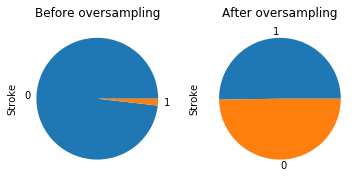

In [24]:
oversampling(y_train, X_train)

## <span style="color:#1155cc;font-style:italic;background-color:#ddd">Logistic Regression Model</span>

In [25]:
import time
start_time = time.time() ## pomiar czasu: start pomiaru czasu
print(time.ctime())
print('Measuring the time to complete this task')

Mon Apr 27 21:33:32 2020
Measuring the time to complete this task


In [26]:
from sklearn import model_selection
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

Parameteres = {'C': np.power(10.0, np.arange(-3, 3))}
LR = LogisticRegression(warm_start = True)
LR_Grid = GridSearchCV(LR, param_grid = Parameteres, scoring = 'roc_auc', n_jobs = -1, cv=2)

LR_Grid.fit(Xtrain_OV, ytrain_OV) 
y_pred_LRC = LR_Grid.predict(X_test)

In [27]:
Time_LR_Grid =((time.time() - start_time)/60) 
Time_LR_Grid = np.round((Time_LR_Grid), decimals=4)
## koniec pomiaru czasu
r,C = (Xtrain_OV.shape )
print('Czas:                                  ',Time_LR_Grid)
Time_LR_Grid_R = np.round((Time_LR_Grid/r)*60*1000, decimals=4)

print('Time for one record in seconds x 1000: ',Time_LR_Grid_R)

Czas:                                   0.0765
Time for one record in seconds x 1000:  0.067


Recall Training data:      0.8291
Precision Training data:   0.7422
----------------------------------------------------------------------
Recall Test data:          0.8025
Precision Test data:       0.0486
----------------------------------------------------------------------
Confusion Matrix Test data
[[6054 2469]
 [  31  126]]
----------------------------------------------------------------------
Valuation for test data only:
              precision    recall  f1-score   support

           0       0.99      0.71      0.83      8523
           1       0.05      0.80      0.09       157

    accuracy                           0.71      8680
   macro avg       0.52      0.76      0.46      8680
weighted avg       0.98      0.71      0.82      8680

---------------------
AUC_train: 0.845
AUC_test:  0.835
---------------------
Accuracy Training data:      0.7694
Accuracy Test data:          0.712
----------------------------------------------------------------------
Valuation for test d

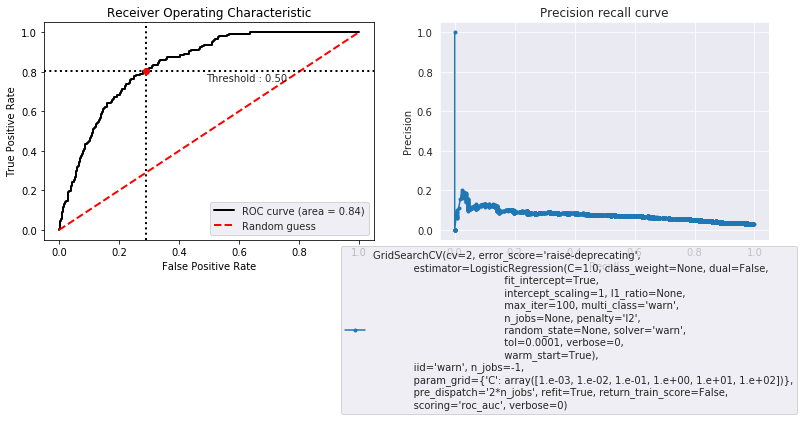

f1 score macro            0.46
f1 score micro            0.712
-----------------------------------------------------------------------------
0 (majority) is better classified than 1 (minority)- micro > macro
Same holds true for AUC
-----------------------------------------------------------------------------
1 proportion: 2.0
0 proportion: 98.0


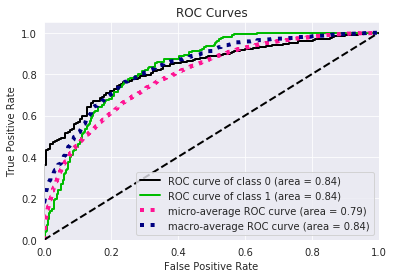

In [28]:
Classification_Assessment(LR_Grid ,Xtrain_OV, ytrain_OV, X_test, y_test)

## <span style="color:#1155cc;font-style:italic;background-color:#ddd">Random Forest Classifier</span>

In [29]:
import time
start_time = time.time() ## pomiar czasu: start pomiaru czasu
print(time.ctime())
print('Measuring the time to complete this task')

Mon Apr 27 21:33:38 2020
Measuring the time to complete this task


In [30]:
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification


from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier (random_state = 1, 
                                  n_estimators = 750, 
                                  max_depth = 2, 
                                  min_samples_split = 2, min_samples_leaf = 3) 
rfc = rfc.fit(Xtrain_OV, ytrain_OV)
y_pred_RFC = rfc.predict(X_test)

In [31]:
Time_CV_rfc =((time.time() - start_time)/60) 
Time_CV_rfc = np.round((Time_CV_rfc), decimals=4)
## koniec pomiaru czasu
r,C = (Xtrain_OV.shape )
print('Czas:                                  ',Time_CV_rfc)
Time_CV_rfc_R = np.round((Time_CV_rfc/r)*60*1000, decimals=4)

print('Time for one record in seconds x 1000: ',Time_CV_rfc_R)

Czas:                                   0.2736
Time for one record in seconds x 1000:  0.2396


Recall Training data:      0.8978
Precision Training data:   0.7256
----------------------------------------------------------------------
Recall Test data:          0.8662
Precision Test data:       0.0456
----------------------------------------------------------------------
Confusion Matrix Test data
[[5674 2849]
 [  21  136]]
----------------------------------------------------------------------
Valuation for test data only:
              precision    recall  f1-score   support

           0       1.00      0.67      0.80      8523
           1       0.05      0.87      0.09       157

    accuracy                           0.67      8680
   macro avg       0.52      0.77      0.44      8680
weighted avg       0.98      0.67      0.79      8680

---------------------
AUC_train: 0.852
AUC_test:  0.840
---------------------
Accuracy Training data:      0.778
Accuracy Test data:          0.6694
----------------------------------------------------------------------
Valuation for test d

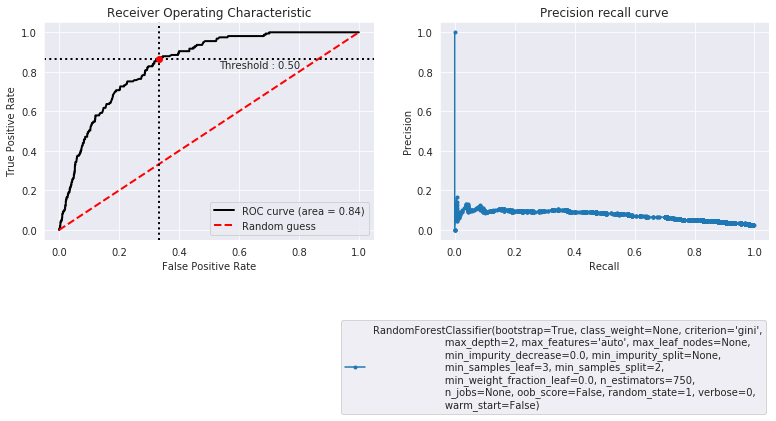

f1 score macro            0.442
f1 score micro            0.669
-----------------------------------------------------------------------------
0 (majority) is better classified than 1 (minority)- micro > macro
Same holds true for AUC
-----------------------------------------------------------------------------
1 proportion: 2.0
0 proportion: 98.0


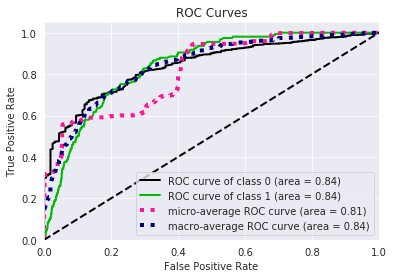

In [32]:
Classification_Assessment(rfc ,Xtrain_OV, ytrain_OV, X_test, y_test)

## <span style="color:#1155cc;font-style:italic;background-color:#ddd">Naive Bayes Classifier</span>

In [33]:
import time
start_time = time.time() ## pomiar czasu: start pomiaru czasu
print(time.ctime())
print('Measuring the time to complete this task')

Mon Apr 27 21:34:10 2020
Measuring the time to complete this task


In [34]:
from sklearn.naive_bayes import GaussianNB
NBC = GaussianNB()
NBC.fit(Xtrain_OV, ytrain_OV)

GaussianNB(priors=None, var_smoothing=1e-09)

y_pred_NBC = NBC.predict(X_test)

In [35]:
Time_NBC =((time.time() - start_time)/60) 
Time_NBC = np.round((Time_NBC), decimals=4)
## koniec pomiaru czasu
r,C = (Xtrain_OV.shape )
print('Czas:                                  ',Time_NBC)
Time_NBC_R = np.round((Time_NBC/r)*60*1000, decimals=4)

print('Time for one record in seconds x 1000: ',Time_NBC_R)

Czas:                                   0.0009
Time for one record in seconds x 1000:  0.0008


Recall Training data:      0.762
Precision Training data:   0.7888
----------------------------------------------------------------------
Recall Test data:          0.7643
Precision Test data:       0.0646
----------------------------------------------------------------------
Confusion Matrix Test data
[[6784 1739]
 [  37  120]]
----------------------------------------------------------------------
Valuation for test data only:
              precision    recall  f1-score   support

           0       0.99      0.80      0.88      8523
           1       0.06      0.76      0.12       157

    accuracy                           0.80      8680
   macro avg       0.53      0.78      0.50      8680
weighted avg       0.98      0.80      0.87      8680

---------------------
AUC_train: 0.849
AUC_test:  0.853
---------------------
Accuracy Training data:      0.7779
Accuracy Test data:          0.7954
----------------------------------------------------------------------
Valuation for test d

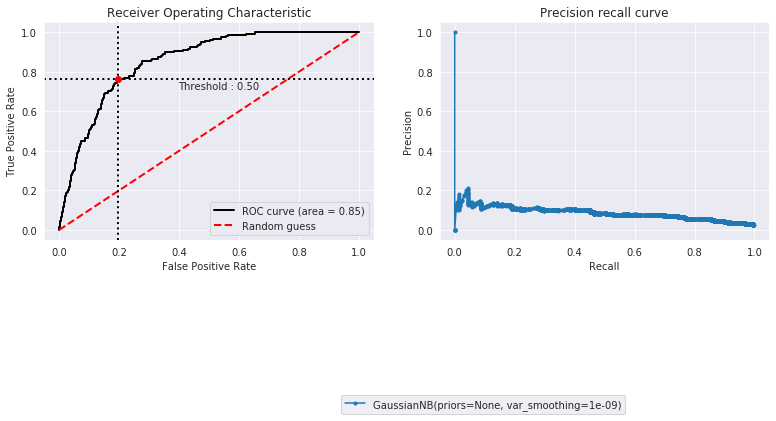

f1 score macro            0.502
f1 score micro            0.795
-----------------------------------------------------------------------------
0 (majority) is better classified than 1 (minority)- micro > macro
Same holds true for AUC
-----------------------------------------------------------------------------
1 proportion: 2.0
0 proportion: 98.0


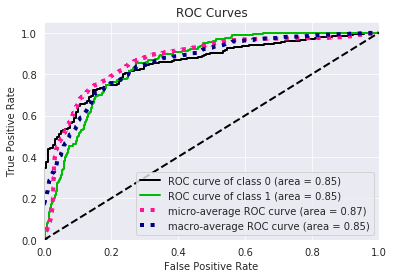

In [36]:
Classification_Assessment(NBC ,Xtrain_OV, ytrain_OV, X_test, y_test)

## <span style="color:#1155cc;font-style:italic;background-color:#ddd">Support Vector Machines - Gaussian</span>

## <span style="color:#1155cc;font-style:italic;background-color:#ddd">Support Vector Machines - linear</span>

## <span style="color:#1155cc;font-style:italic;background-color:#ddd">CatBoost</span>

In [37]:
## Potrzebujemy listy z numerami kolumn kategorycznych dla CatBoost

import numpy as np
a,b = df.shape     #<- ile mamy kolumn
b

print()
cat_fun2 = np.where(df.dtypes == np.object)[0]    #|(df2.nunique() <= 3)
x1 = len(cat_fun2)
print('cat_fun2: ',x1)
print('cat_fun2: ',cat_fun2)


cat_fun2:  5
cat_fun2:  [ 1  5  6  7 10]


In [38]:
import time
start_time = time.time() ## pomiar czasu: start pomiaru czasu
print(time.ctime())
print('Measuring the time to complete this task')

Mon Apr 27 21:34:12 2020
Measuring the time to complete this task


In [39]:
from catboost import CatBoostClassifier, Pool, cv

params = {
    'iterations': 500,
    'learning_rate': 0.1,
    'eval_metric': 'Accuracy',
    'random_seed': 148,
    'logging_level': 'Silent',
    'use_best_model': False,
    'od_type': 'Iter',
    'od_wait': 40
}

train_pool = Pool(Xtrain_OV, ytrain_OV, cat_features=cat_fun2)
validate_pool = Pool(X_test, y_test, cat_features=cat_fun2)

CBC = CatBoostClassifier(**params)
CBC.fit(train_pool, eval_set=validate_pool, plot=False)

In [40]:
Time_CBC =((time.time() - start_time)/60) 
Time_CBC = np.round((Time_CBC), decimals=4)
## koniec pomiaru czasu
r,C = (Xtrain_OV.shape )
print('Time:                                  ',Time_CBC)
Time_CBC_R = np.round((Time_CBC/r)*60*1000, decimals=4)

print('Time for one record in seconds x 1000: ',Time_CBC_R)

Time:                                   0.4108
Time for one record in seconds x 1000:  0.3597


Recall Training data:      1.0
Precision Training data:   0.9699
----------------------------------------------------------------------
Recall Test data:          0.2803
Precision Test data:       0.0969
----------------------------------------------------------------------
Confusion Matrix Test data
[[8113  410]
 [ 113   44]]
----------------------------------------------------------------------
Valuation for test data only:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      8523
           1       0.10      0.28      0.14       157

    accuracy                           0.94      8680
   macro avg       0.54      0.62      0.56      8680
weighted avg       0.97      0.94      0.95      8680

---------------------
AUC_train: 0.999
AUC_test:  0.792
---------------------
Accuracy Training data:      0.9844
Accuracy Test data:          0.9397
----------------------------------------------------------------------
Valuation for test dat

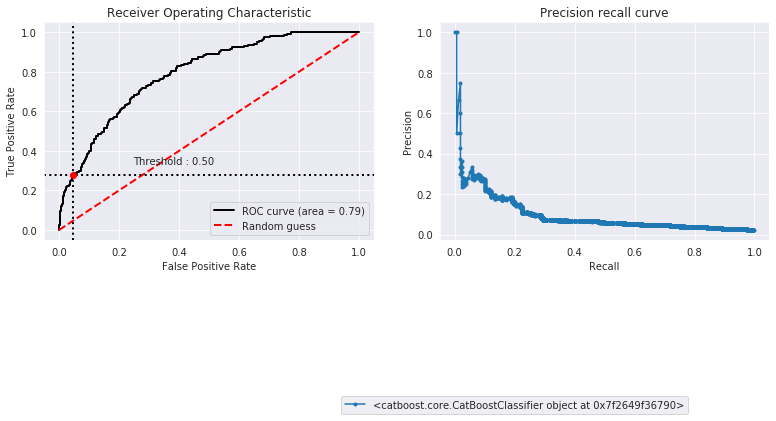

f1 score macro            0.556
f1 score micro            0.94
-----------------------------------------------------------------------------
0 (majority) is better classified than 1 (minority)- micro > macro
Same holds true for AUC
-----------------------------------------------------------------------------
1 proportion: 2.0
0 proportion: 98.0


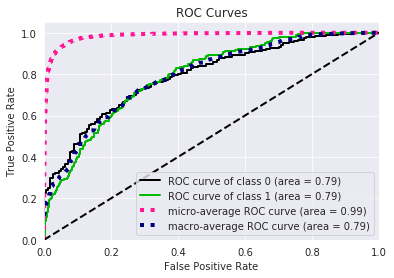

In [41]:
Classification_Assessment(CBC ,Xtrain_OV, ytrain_OV, X_test, y_test)

## <span style="color:green"> Ocena modeli

In [42]:
from sklearn import metrics
from sklearn.metrics import accuracy_score


print('Logistic Regression Model:') 
print('Time in min.: ', Time_LR_Grid)      
print('validation accuracy:   {:.4}'.format(accuracy_score(y_test, LR_Grid.predict(X_test))))
AUC_train_LR_Grid = metrics.roc_auc_score(ytrain_OV,LR_Grid.predict_proba(Xtrain_OV)[:,1])
print('AUC_train:                   %.3f' % AUC_train_LR_Grid)
AUC_test_LR_Grid = metrics.roc_auc_score(y_test,LR_Grid.predict_proba(X_test)[:,1])
print('AUC_test:                    %.3f' % AUC_test_LR_Grid)

print("Accuracy Training data:     ", np.round(accuracy_score(ytrain_OV, LR_Grid.predict(Xtrain_OV)), decimals=4))
print("Accuracy Test data:         ", np.round(accuracy_score(y_test, LR_Grid.predict(X_test)), decimals=4)) 



print('------------------------------------------')
print('Random Forest Classifier:') 
print('Time in min.: ', Time_CV_rfc)      
print('validation accuracy:   {:.4}'.format(accuracy_score(y_test, rfc.predict(X_test))))
AUC_train_rfc = metrics.roc_auc_score(ytrain_OV,rfc.predict_proba(Xtrain_OV)[:,1])
print('AUC_train:                   %.3f' % AUC_train_rfc)
AUC_test_rfc = metrics.roc_auc_score(y_test,rfc.predict_proba(X_test)[:,1])
print('AUC_test:                    %.3f' % AUC_test_rfc)

print("Accuracy Training data:     ", np.round(accuracy_score(ytrain_OV, rfc.predict(Xtrain_OV)), decimals=4))
print("Accuracy Test data:         ", np.round(accuracy_score(y_test, rfc.predict(X_test)), decimals=4)) 



print('------------------------------------------')
print('Naive Bayes Classifier:') 
print('Time in min.: ', Time_NBC)      
print('validation accuracy:   {:.4}'.format(accuracy_score(y_test, NBC.predict(X_test))))
AUC_train_NBC = metrics.roc_auc_score(ytrain_OV,NBC.predict_proba(Xtrain_OV)[:,1])
print('AUC_train:                   %.3f' % AUC_train_NBC)
AUC_test_NBC = metrics.roc_auc_score(y_test,NBC.predict_proba(X_test)[:,1])
print('AUC_test:                    %.3f' % AUC_test_NBC)

print("Accuracy Training data:     ", np.round(accuracy_score(ytrain_OV, NBC.predict(Xtrain_OV)), decimals=4))
print("Accuracy Test data:         ", np.round(accuracy_score(y_test, NBC.predict(X_test)), decimals=4)) 


print('------------------------------------------')
print('CatBoost:') 
print('Time in min.: ', Time_CBC)      
print('validation accuracy:   {:.4}'.format(accuracy_score(y_test, CBC.predict(X_test))))
AUC_train_CBC = metrics.roc_auc_score(ytrain_OV,CBC.predict_proba(Xtrain_OV)[:,1])
print('AUC_train:                   %.3f' % AUC_train_CBC)
AUC_test_CBC = metrics.roc_auc_score(y_test,CBC.predict_proba(X_test)[:,1])
print('AUC_test:                    %.3f' % AUC_test_CBC)

print("Accuracy Training data:     ", np.round(accuracy_score(ytrain_OV, CBC.predict(Xtrain_OV)), decimals=4))
print("Accuracy Test data:         ", np.round(accuracy_score(y_test, CBC.predict(X_test)), decimals=4)) 


Logistic Regression Model:
Time in min.:  0.0765
validation accuracy:   0.712
AUC_train:                   0.845
AUC_test:                    0.835
Accuracy Training data:      0.7694
Accuracy Test data:          0.712
------------------------------------------
Random Forest Classifier:
Time in min.:  0.2736
validation accuracy:   0.6694
AUC_train:                   0.852
AUC_test:                    0.840
Accuracy Training data:      0.778
Accuracy Test data:          0.6694
------------------------------------------
Naive Bayes Classifier:
Time in min.:  0.0009
validation accuracy:   0.7954
AUC_train:                   0.849
AUC_test:                    0.853
Accuracy Training data:      0.7779
Accuracy Test data:          0.7954
------------------------------------------
CatBoost:
Time in min.:  0.4108
validation accuracy:   0.9397
AUC_train:                   0.999
AUC_test:                    0.792
Accuracy Training data:      0.9844
Accuracy Test data:          0.9397
